This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting heart failure onset risk using pytorch library
* For this demonstration, the data is the original 1 hospital (h143) previously used by retain, with 42,729 patients in total
* The logistic regression model has the architecture of an embedding layer (embedding dimension =128), a linear activation and sigmoid transformation. The model takes in a pretrained embedding file from retain ("emb_merged.tsv") with dimension (15815, 128). The hyperparameters used are bayesian optimized already (lr= np.exp(-8.8379), L2= np.exp(-6.6844))
* Our model achieves overall 0.8034 test auc, with corresponding 0.7785 validation auc on epoch 9
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end
* Since github does not render Plotly graph, we upload a static one, and if you're curious about the original interactive plot, you can also click on the link provided

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random

import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle

In [10]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_preemb as model
import Loaddata_final as Loaddata
import TrainVaTe as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=0.001, help='initial learning rate [default: 0.001]')
parser.add_argument('-L2', type=float, default=0.00001, help='L2 regularization [default: 0.00001]')
parser.add_argument('-epochs', type=int, default=5, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=2, help='number of embedding dimension [default: 2]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr= np.exp(-8.8379)
args.L2= np.exp(-6.6844)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
args.seq_file = 'Data/h143.visits'
args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [7]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit])  
else: 
    model_x = set_x     
    
merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)


Loading and preparing data...

Sample data after split:
[0, [1667, 144, 62, 85, 1667, 144, 62, 85]]
model is LR


In [11]:
emb_pretrain = np.loadtxt(open("emb_merged.tsv", "rb"), delimiter="\t", skiprows=1, usecols=range(2,130))
emb_mt= np.asmatrix(emb_pretrain)
print(emb_mt.shape)
emb_t= torch.FloatTensor(emb_mt)
emb_t.size()

(15815, 128)


torch.Size([15815, 128])

In [12]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size, embed_dim = 128)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

#optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, ehr_model.parameters()), lr=args.lr, weight_decay=args.L2) #,eps=epsl) ### Beta defaults (0.9, 0.999)

In [13]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]

In [14]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.673655144634192
[1.3919076736756324, 1.1198002026846208, 1.139340672130343, 0.9749029752183294, 0.9892272212507166, 0.735802152181817, 0.7748981026871993, 0.6556588172641055, 0.7576221858322347, 0.6762921297657551, 0.6852938951192857, 0.6766786076598658, 0.5017869170166811, 0.5201148182729842, 0.6136962312718957, 0.48881035212526425, 0.5644692536177325, 0.6075366418584692, 0.5508982761073571, 0.4346635520548945, 0.4784440113644406, 0.6097652184282832, 0.4387531147329712, 0.5409843013348768, 0.4826674437447881, 0.5934627238927127, 0.5584877508253405, 0.46727299557479873, 0.5067609566981743] 
 train loss plot


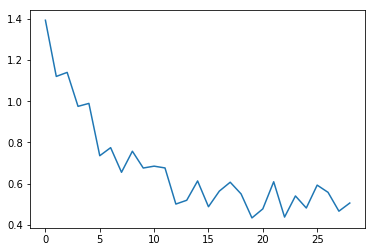


 Current running on: Epoch  0  Training auc: 0.716735818389411


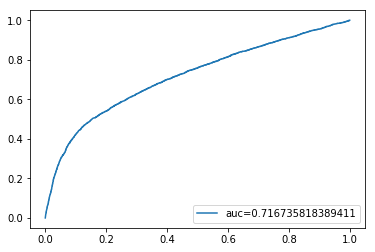


 Current running on: Epoch  0  validation auc: 0.6785827668302107


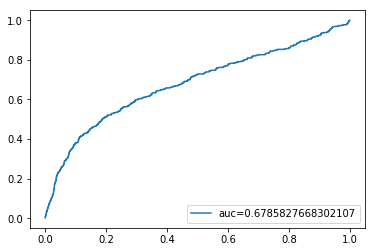


 Current running on: Epoch  0  test auc: 0.706505221260766


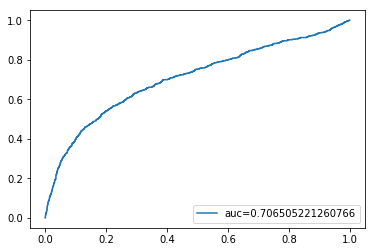

Epoch  0 Summary:  Training_auc : 0.716735818389411  , Validation_auc :  0.6785827668302107  ,& Test_auc :  0.706505221260766  Avg Loss:  0.673655144634192 Train Time (0m 53s) Eval Time (0m 16s)

 Current running on: Epoch  1 Training loss:  Average loss 0.4200156313110291
[0.39919665728612197, 0.4553185507186751, 0.41030674824269203, 0.39353771803850673, 0.3797629277778041, 0.4583907328342961, 0.43527764250596884, 0.43165268925337014, 0.374484520713862, 0.5342044584030048, 0.38197341236313387, 0.4374716560939672, 0.37977297313913927, 0.4587923460540941, 0.434773901024123, 0.45558339383377994, 0.436753540206087, 0.4350609456612268, 0.4021055880676984, 0.43492047173705406, 0.4403936294000731, 0.43123976653803026, 0.4171422774173177, 0.33662886162337546, 0.4032031427007202, 0.38450661912878503, 0.41884675834153656, 0.39380506784371183, 0.42534631107168913] 
 train loss plot


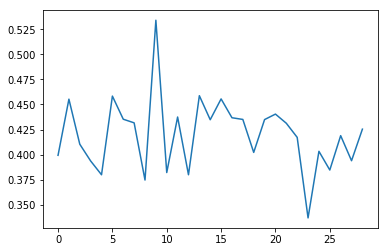


 Current running on: Epoch  1  Training auc: 0.6795791542334337


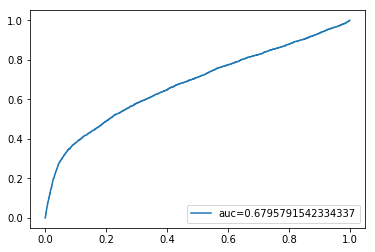


 Current running on: Epoch  1  validation auc: 0.6486516761225014


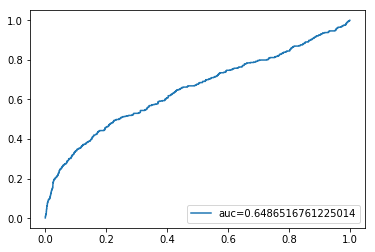


 Current running on: Epoch  1  test auc: 0.6841116840445809


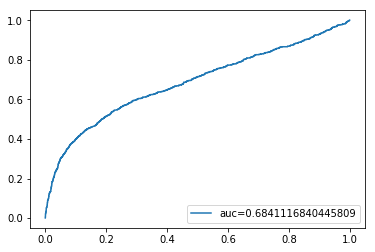

Epoch  1 Summary:  Training_auc : 0.6795791542334337  , Validation_auc :  0.6486516761225014  ,& Test_auc :  0.6841116840445809  Avg Loss:  0.4200156313110291 Train Time (0m 54s) Eval Time (0m 23s)

 Current running on: Epoch  2 Training loss:  Average loss 0.3874838638320696
[0.41437361888150476, 0.3491821286364479, 0.34388393570167647, 0.3943487531926903, 0.39642476422639195, 0.39079567109470453, 0.40264959725961497, 0.38808807457720185, 0.4054170789742951, 0.37023540402172184, 0.37987346403960076, 0.43340256242102887, 0.4001465688752902, 0.4032887674193237, 0.38856137743907354, 0.34587534763533145, 0.4573879152857522, 0.35294509653607503, 0.3639779091273804, 0.35319155039470207, 0.3450609489089501, 0.44980521338960383, 0.3439008794726894, 0.3723975039774792, 0.32392125721707055, 0.4591376444895084, 0.3682244760628962, 0.43090886305131426, 0.4096256788206978] 
 train loss plot


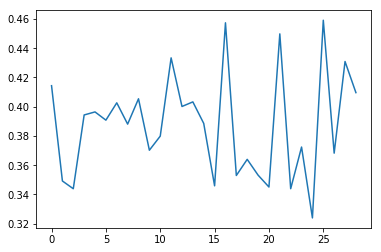


 Current running on: Epoch  2  Training auc: 0.755056430972574


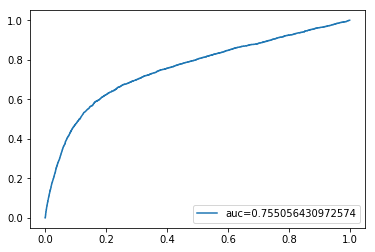


 Current running on: Epoch  2  validation auc: 0.7221276911971943


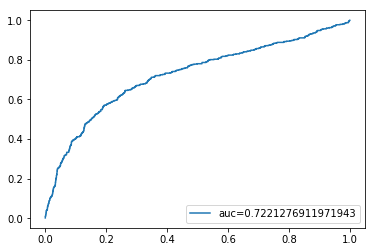


 Current running on: Epoch  2  test auc: 0.757471696358375


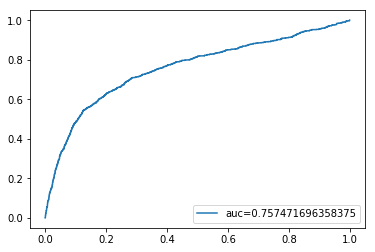

Epoch  2 Summary:  Training_auc : 0.755056430972574  , Validation_auc :  0.7221276911971943  ,& Test_auc :  0.757471696358375  Avg Loss:  0.3874838638320696 Train Time (0m 57s) Eval Time (0m 16s)

 Current running on: Epoch  3 Training loss:  Average loss 0.3758071203089999
[0.3541185441604366, 0.4045406711697443, 0.3758957984521653, 0.34044062734798525, 0.3828837372798504, 0.3640230577419166, 0.3350397051512722, 0.3961023067649148, 0.3983490609316766, 0.4673754138495341, 0.351868781949554, 0.33518083999448767, 0.37507782609656243, 0.42394160276301773, 0.33611618427334333, 0.3265106574665173, 0.415275255060643, 0.37660956903464754, 0.37591258326301114, 0.35973684745724394, 0.4419041139798866, 0.36925917871740904, 0.3951102930651664, 0.3329406362223131, 0.3526262327308675, 0.37328086661598897, 0.4191620882971823, 0.33398171652286224, 0.3851422926007939] 
 train loss plot


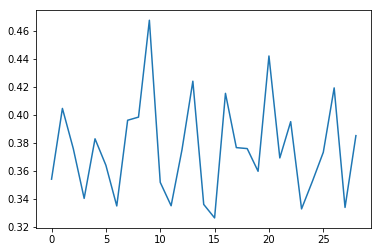


 Current running on: Epoch  3  Training auc: 0.7563523068921666


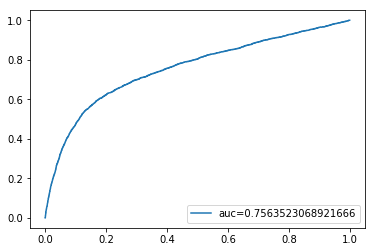


 Current running on: Epoch  3  validation auc: 0.7159635033744298


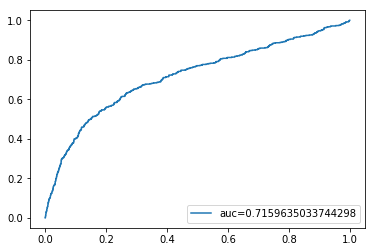


 Current running on: Epoch  3  test auc: 0.7591492060349556


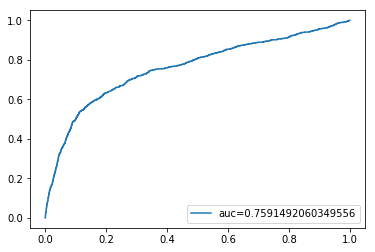

Epoch  3 Summary:  Training_auc : 0.7563523068921666  , Validation_auc :  0.7159635033744298  ,& Test_auc :  0.7591492060349556  Avg Loss:  0.3758071203089999 Train Time (0m 54s) Eval Time (0m 16s)

 Current running on: Epoch  4 Training loss:  Average loss 0.3705272093807738
[0.3814780109309569, 0.4086124493033197, 0.34807475166457214, 0.38049037665071556, 0.44414820978776265, 0.32821299135213666, 0.3540147494239162, 0.32912653678306525, 0.3929351612752878, 0.4007993704402258, 0.373814895909283, 0.3659372946928525, 0.37557904112577234, 0.37098344345507445, 0.2828716370535612, 0.41483411749540666, 0.38694883815701403, 0.34665461428682304, 0.3791367205856652, 0.3729035455214007, 0.3714133206108305, 0.384335337909881, 0.358350693916932, 0.37010954088376935, 0.3810140905351104, 0.37106165238433036, 0.3640958316330057, 0.3655664739059743, 0.34178537436779705] 
 train loss plot


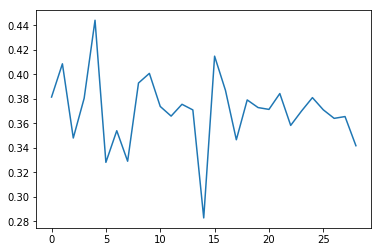


 Current running on: Epoch  4  Training auc: 0.7627020530177696


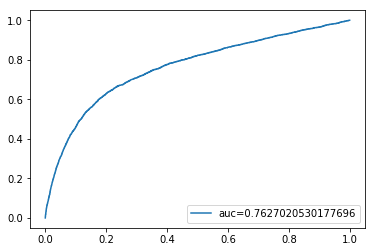


 Current running on: Epoch  4  validation auc: 0.7275618590810164


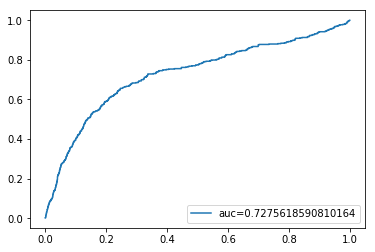


 Current running on: Epoch  4  test auc: 0.7593023806033813


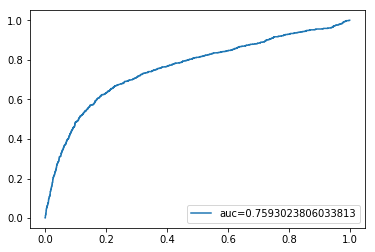

Epoch  4 Summary:  Training_auc : 0.7627020530177696  , Validation_auc :  0.7275618590810164  ,& Test_auc :  0.7593023806033813  Avg Loss:  0.3705272093807738 Train Time (0m 53s) Eval Time (0m 16s)

 Current running on: Epoch  5 Training loss:  Average loss 0.3618410209616284
[0.39703592193287957, 0.36145712722159384, 0.3414415990955109, 0.3640263691059763, 0.3688197002813523, 0.3588487308910506, 0.3928349951293385, 0.3425505820544878, 0.3534201282181888, 0.34012936532929455, 0.3201604791145263, 0.37850081950121056, 0.3293852105658611, 0.3951048688328461, 0.3678878667767267, 0.3396345975015397, 0.40123273947620713, 0.3547253526966022, 0.3709555679727716, 0.4248860304221492, 0.3761346744533123, 0.3504375602488646, 0.34606356265223637, 0.3588664167539112, 0.37159253016153865, 0.352366529530614, 0.30249165253031574, 0.3954953398551861, 0.3369032895811305] 
 train loss plot


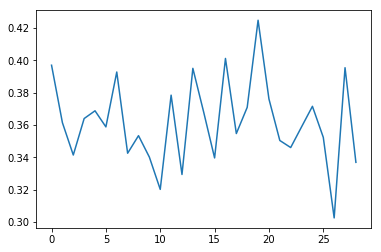


 Current running on: Epoch  5  Training auc: 0.7597499479737593


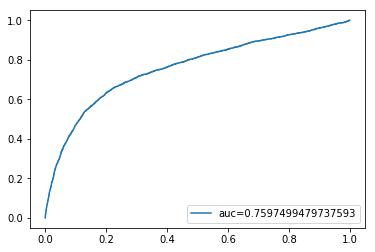


 Current running on: Epoch  5  validation auc: 0.7274214285987497


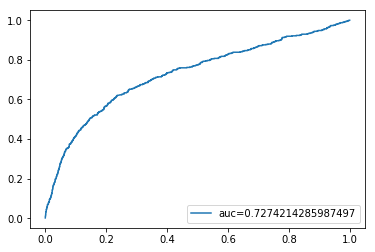


 Current running on: Epoch  5  test auc: 0.7640516080678194


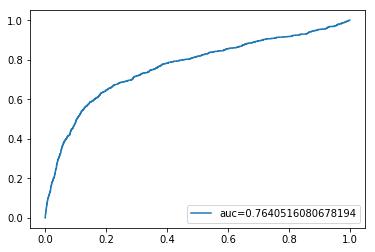

Epoch  5 Summary:  Training_auc : 0.7597499479737593  , Validation_auc :  0.7274214285987497  ,& Test_auc :  0.7640516080678194  Avg Loss:  0.3618410209616284 Train Time (0m 52s) Eval Time (0m 16s)

 Current running on: Epoch  6 Training loss:  Average loss 0.3617027340922812
[0.36632640067528716, 0.4087627527979507, 0.3511873515234629, 0.3924108124493478, 0.32338833421747815, 0.398545156759755, 0.32949307450640525, 0.36560532676862934, 0.3858806081848527, 0.34679705135909705, 0.3421615470627078, 0.3465513851049411, 0.3817244937593423, 0.4137459222835162, 0.31384531309609837, 0.3440441519093448, 0.3448444856188728, 0.3658833789748928, 0.36234967729291245, 0.3673756079897784, 0.3725193369149793, 0.3824063451306175, 0.3552055432759453, 0.3460411935910048, 0.3247635607767097, 0.3156624829126705, 0.4339280476906215, 0.34620708780504217, 0.36172285824389133] 
 train loss plot


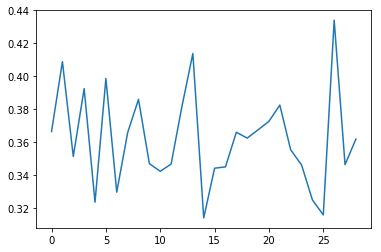


 Current running on: Epoch  6  Training auc: 0.7649866302377706


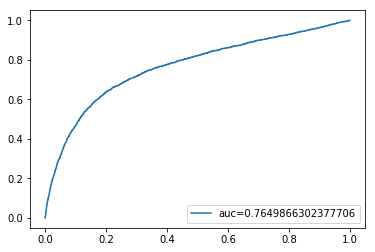


 Current running on: Epoch  6  validation auc: 0.7269179006243965


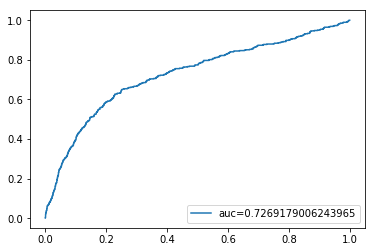


 Current running on: Epoch  6  test auc: 0.7682593875682351


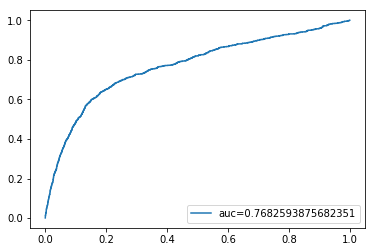

Epoch  6 Summary:  Training_auc : 0.7649866302377706  , Validation_auc :  0.7269179006243965  ,& Test_auc :  0.7682593875682351  Avg Loss:  0.3617027340922812 Train Time (0m 54s) Eval Time (0m 16s)

 Current running on: Epoch  7 Training loss:  Average loss 0.35553397686791144
[0.38003394058061485, 0.3335823381158093, 0.31516375627707816, 0.355299167822546, 0.35607991677422685, 0.3727370044212682, 0.3632237297032971, 0.33343399460879636, 0.36453909012066255, 0.3581714378517511, 0.32903434709785406, 0.37059935303189434, 0.3602517448230292, 0.32890435848387833, 0.33883096510312727, 0.38027208829097414, 0.3853044826186275, 0.3846562131372116, 0.3843705975572485, 0.3710311333109505, 0.3772623596176557, 0.32964198690201285, 0.37277405284710946, 0.37919265155872905, 0.3663984623866192, 0.3394659405166579, 0.3131314741232768, 0.31771898278343647, 0.34937975870308946] 
 train loss plot


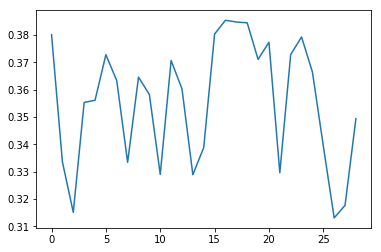


 Current running on: Epoch  7  Training auc: 0.708447555970248


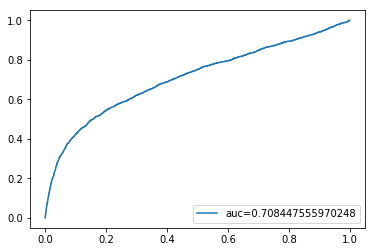


 Current running on: Epoch  7  validation auc: 0.6728360454994762


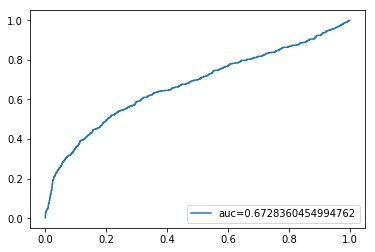


 Current running on: Epoch  7  test auc: 0.7136199182144345


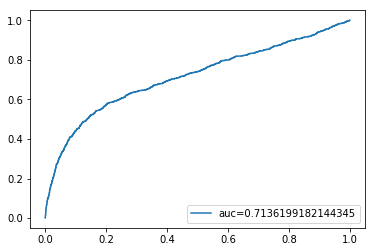

Epoch  7 Summary:  Training_auc : 0.708447555970248  , Validation_auc :  0.6728360454994762  ,& Test_auc :  0.7136199182144345  Avg Loss:  0.35553397686791144 Train Time (0m 54s) Eval Time (0m 16s)

 Current running on: Epoch  8 Training loss:  Average loss 0.3517300357341748
[0.3317950566685333, 0.346222205854624, 0.32747079735417106, 0.38284130349875367, 0.34385321507046307, 0.36544411639359736, 0.3536544274057952, 0.34138255098781667, 0.33761740522159583, 0.31201180546757157, 0.31600795480341093, 0.4231477785580139, 0.3763806104362359, 0.3441459120082148, 0.3477347885663431, 0.3523099067023858, 0.35142516201783497, 0.34153581953871753, 0.3258252012649116, 0.36268556232108623, 0.379264697137326, 0.37766889161190415, 0.34398178673551244, 0.3558468765455427, 0.3616423019680033, 0.3020655226163767, 0.36645998761568377, 0.3499649783783884, 0.3797844135422527] 
 train loss plot


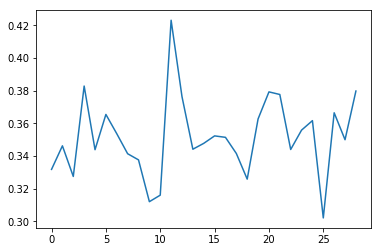


 Current running on: Epoch  8  Training auc: 0.7714854343171058


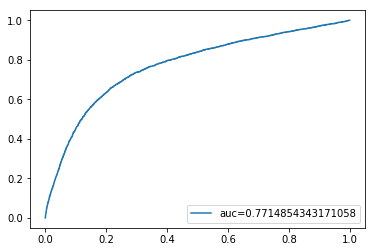


 Current running on: Epoch  8  validation auc: 0.7429665912057732


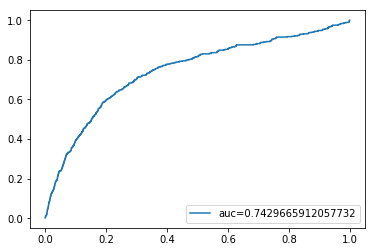


 Current running on: Epoch  8  test auc: 0.7666075089667971


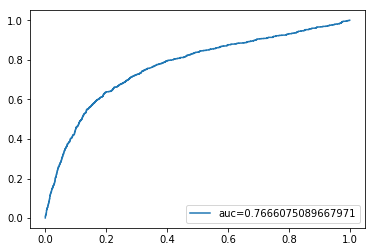

Epoch  8 Summary:  Training_auc : 0.7714854343171058  , Validation_auc :  0.7429665912057732  ,& Test_auc :  0.7666075089667971  Avg Loss:  0.3517300357341748 Train Time (0m 53s) Eval Time (0m 16s)

 Current running on: Epoch  9 Training loss:  Average loss 0.3509107151890189
[0.33326920168268204, 0.34168558462943033, 0.35212851960609265, 0.3373709539028122, 0.33450567546124116, 0.39876080043328327, 0.3570520502362361, 0.3231859247748537, 0.35333149020913085, 0.38916468137865307, 0.332581050614298, 0.3728393476637305, 0.3683121091732364, 0.3218676190080026, 0.3214231531120396, 0.32825588246670334, 0.3669626176306483, 0.34424708407388427, 0.381067015998579, 0.34235197197929756, 0.3173341839462404, 0.35090997942153, 0.31958547530657416, 0.3643540618295695, 0.3822222187157054, 0.3806321679707089, 0.37883585742355474, 0.34466118931332185, 0.3375128725195084] 
 train loss plot


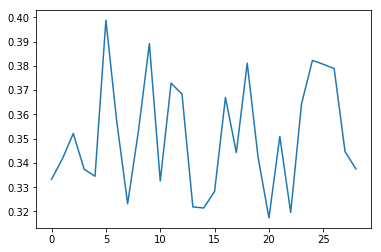


 Current running on: Epoch  9  Training auc: 0.7899710639780211


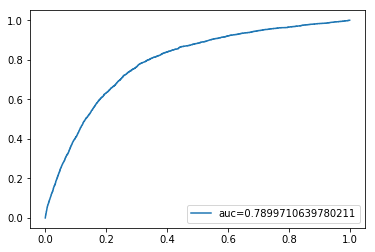


 Current running on: Epoch  9  validation auc: 0.7785403098322649


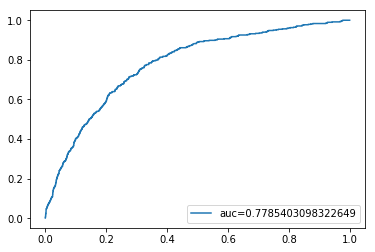


 Current running on: Epoch  9  test auc: 0.8033573717011719


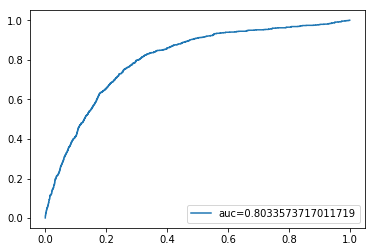

Epoch  9 Summary:  Training_auc : 0.7899710639780211  , Validation_auc :  0.7785403098322649  ,& Test_auc :  0.8033573717011719  Avg Loss:  0.3509107151890189 Train Time (0m 54s) Eval Time (0m 16s)

 Current running on: Epoch  10 Training loss:  Average loss 0.344710283732202
[0.32219155888514545, 0.2782681009257549, 0.38809428454071704, 0.3711129964158166, 0.35450378029827184, 0.3205186437259604, 0.36029699437716206, 0.33629684536112836, 0.3449594111274146, 0.28565782859387584, 0.3688151186984906, 0.33836806866985897, 0.4002872657284461, 0.37279125820347775, 0.37419463057155783, 0.4048048442261561, 0.3615570153700094, 0.3183989145367875, 0.3136749128504962, 0.3408126590882223, 0.3524419205904813, 0.36390332885565296, 0.3507799595758568, 0.3119428233333033, 0.335790121510081, 0.3387813278966214, 0.3028364739449031, 0.33127676953561913, 0.3532403707965892] 
 train loss plot


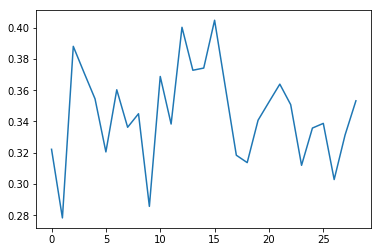


 Current running on: Epoch  10  Training auc: 0.7826312828194244


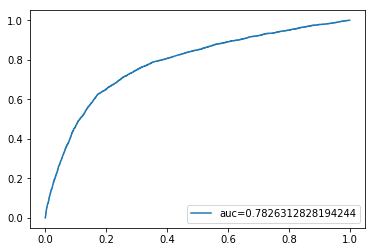


 Current running on: Epoch  10  validation auc: 0.766442251106095


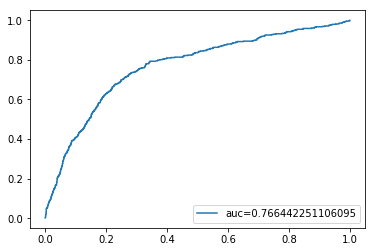


 Current running on: Epoch  10  test auc: 0.7833070042589736


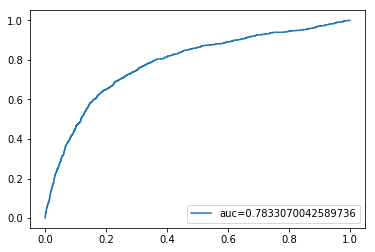

Epoch  10 Summary:  Training_auc : 0.7826312828194244  , Validation_auc :  0.766442251106095  ,& Test_auc :  0.7833070042589736  Avg Loss:  0.344710283732202 Train Time (0m 51s) Eval Time (0m 16s)

 Current running on: Epoch  11 Training loss:  Average loss 0.3441053984689151
[0.3034498877193588, 0.34208571168396157, 0.35272934599860456, 0.3469616001502873, 0.34031206536135006, 0.3626757176703904, 0.327274347871946, 0.3064964787540622, 0.3432465352443485, 0.3819570688472116, 0.33268301772681436, 0.3447056993359569, 0.30680442853796125, 0.32781910862578023, 0.38117172601207777, 0.34223615124365914, 0.3531373742811602, 0.3231089558530266, 0.36724242391724815, 0.3295192273352773, 0.3718428753502302, 0.34434049711967024, 0.3107204838934449, 0.33060792112050047, 0.3751975027326589, 0.35716137988554714, 0.368248473073252, 0.3409776302003104, 0.3643429200524422] 
 train loss plot


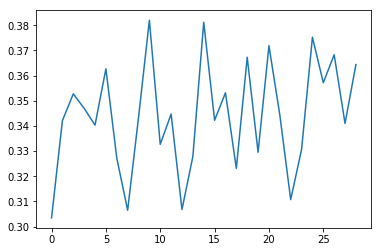


 Current running on: Epoch  11  Training auc: 0.7871803512466922


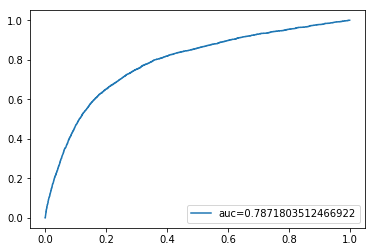


 Current running on: Epoch  11  validation auc: 0.776754055954717


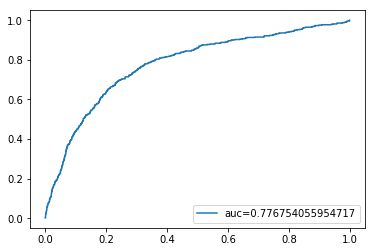


 Current running on: Epoch  11  test auc: 0.7945756350591773


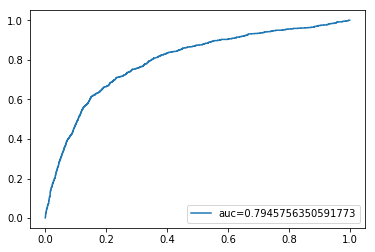

Epoch  11 Summary:  Training_auc : 0.7871803512466922  , Validation_auc :  0.776754055954717  ,& Test_auc :  0.7945756350591773  Avg Loss:  0.3441053984689151 Train Time (0m 52s) Eval Time (0m 16s)

 Current running on: Epoch  12 Training loss:  Average loss 0.34175478937778364
[0.31884796228315704, 0.3134876472222113, 0.3508708725654262, 0.29933152646903544, 0.360947281287653, 0.3863441654984781, 0.32110721814131604, 0.35406436221934007, 0.3238450284483272, 0.38703493975340736, 0.31041925691007716, 0.31329268930830895, 0.324354303383011, 0.3393414772492806, 0.33798982686067175, 0.3722480062296418, 0.378366952290275, 0.3450458429985654, 0.3259270612489754, 0.35946597243875383, 0.2939637555649806, 0.3700521457189608, 0.3802941737797289, 0.34012052629391315, 0.34783743101080306, 0.3144699588840831, 0.3637759293550862, 0.35268745771215615, 0.32535512083010326] 
 train loss plot


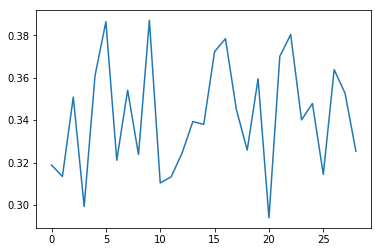


 Current running on: Epoch  12  Training auc: 0.7720630578950055


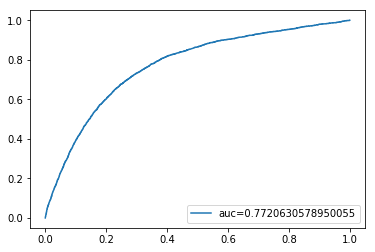


 Current running on: Epoch  12  validation auc: 0.751464547860293


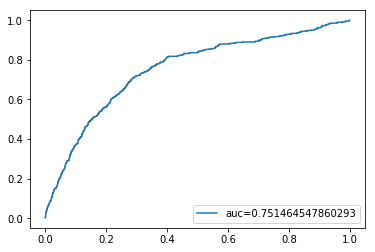


 Current running on: Epoch  12  test auc: 0.7865475336107018


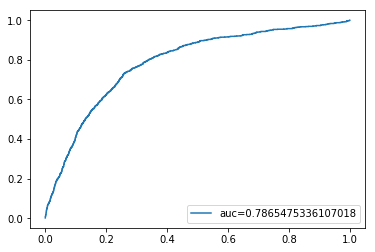

Epoch  12 Summary:  Training_auc : 0.7720630578950055  , Validation_auc :  0.751464547860293  ,& Test_auc :  0.7865475336107018  Avg Loss:  0.34175478937778364 Train Time (0m 54s) Eval Time (0m 16s)

 Current running on: Epoch  13 Training loss:  Average loss 0.3387355963124597
[0.32948002974103746, 0.33418103579348674, 0.3331057238439003, 0.34009617047923646, 0.3388549093293391, 0.3236212555962884, 0.3081980487083019, 0.31524178825858695, 0.3342747826414293, 0.35953388720504426, 0.3529279393002908, 0.34492914381435386, 0.3201273506821119, 0.3439790860423143, 0.34545853975737284, 0.3134245886012498, 0.3688337428334226, 0.352645072205904, 0.33479741685745373, 0.3447966910421327, 0.38986832089612994, 0.3141106826195869, 0.3497967967297327, 0.3600076766918046, 0.3441189131672836, 0.30995678769189633, 0.3309737825050443, 0.3389490600320087, 0.34704306999458456] 
 train loss plot


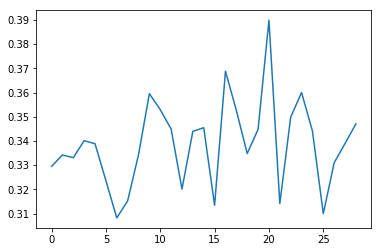


 Current running on: Epoch  13  Training auc: 0.7630097237854754


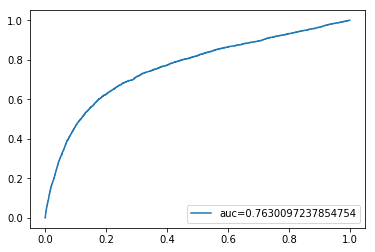


 Current running on: Epoch  13  validation auc: 0.7346096114556302


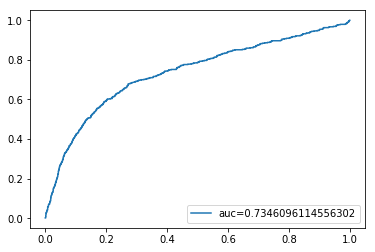


 Current running on: Epoch  13  test auc: 0.7600902812130066


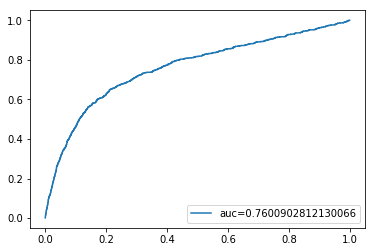

Epoch  13 Summary:  Training_auc : 0.7630097237854754  , Validation_auc :  0.7346096114556302  ,& Test_auc :  0.7600902812130066  Avg Loss:  0.3387355963124597 Train Time (0m 54s) Eval Time (0m 16s)

 Current running on: Epoch  14 Training loss:  Average loss 0.33743726516010497
[0.32874631191195747, 0.3384995955446218, 0.3542631456780582, 0.38717527845371114, 0.34167113456348674, 0.3429108524283911, 0.320295693565678, 0.3221375838057529, 0.3031099896225371, 0.33110951698039287, 0.3304236354085738, 0.36811151081057003, 0.35357652935592887, 0.34386002975780405, 0.3297838643436962, 0.3285161317818274, 0.3242260900160354, 0.3233959216673885, 0.3533166583034017, 0.34362180168746864, 0.3414284184569229, 0.32943937648675603, 0.3318522447514624, 0.32724286087175414, 0.307690758123048, 0.37316257585124274, 0.3260246426037065, 0.3363483135341939, 0.3437402232766783] 
 train loss plot


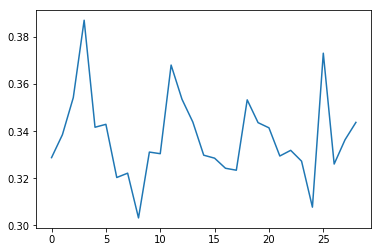


 Current running on: Epoch  14  Training auc: 0.778548433954672


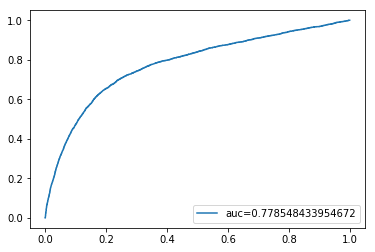


 Current running on: Epoch  14  validation auc: 0.7430496473664914


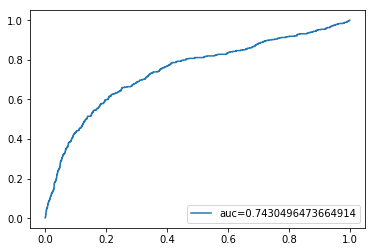


 Current running on: Epoch  14  test auc: 0.7898000286632925


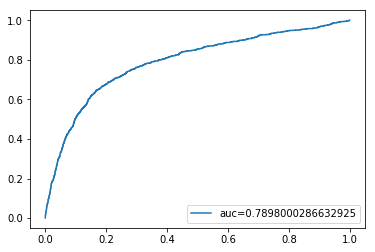

Epoch  14 Summary:  Training_auc : 0.778548433954672  , Validation_auc :  0.7430496473664914  ,& Test_auc :  0.7898000286632925  Avg Loss:  0.33743726516010497 Train Time (0m 55s) Eval Time (0m 16s)

 Current running on: Epoch  15 Training loss:  Average loss 0.33755099727706694
[0.2822023775262433, 0.3543848482676708, 0.3594989313762217, 0.34806895174671276, 0.3156183640802037, 0.36827235684105836, 0.3225569141680414, 0.37945247374689645, 0.3652042407606423, 0.3219019189706346, 0.3398877264363573, 0.34290033996943414, 0.3454577954525557, 0.3509836701766972, 0.3174491692065949, 0.3428438724306834, 0.30961806029804173, 0.3469948179569426, 0.31399676102506097, 0.36742279492299806, 0.31623710134379635, 0.3219571192105233, 0.34436821270813833, 0.34558715808569124, 0.34783485347413806, 0.3228294595998232, 0.32548551671678694, 0.3762501633110296, 0.29371295122532326] 
 train loss plot


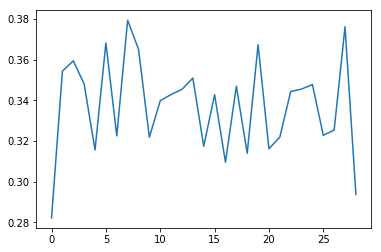


 Current running on: Epoch  15  Training auc: 0.7564114819395109


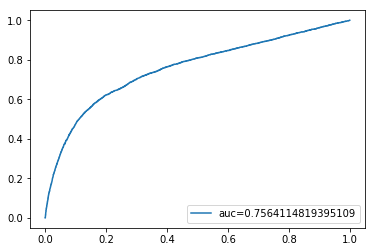


 Current running on: Epoch  15  validation auc: 0.7220266031068469


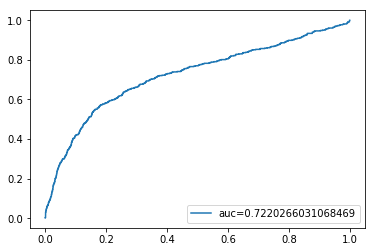


 Current running on: Epoch  15  test auc: 0.7544320684046485


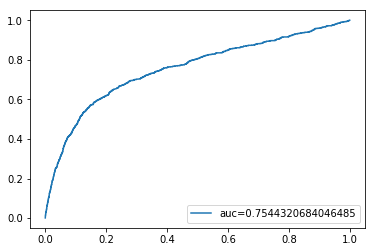

Epoch  15 Summary:  Training_auc : 0.7564114819395109  , Validation_auc :  0.7220266031068469  ,& Test_auc :  0.7544320684046485  Avg Loss:  0.33755099727706694 Train Time (0m 53s) Eval Time (0m 16s)

 Current running on: Epoch  16 Training loss:  Average loss 0.3346746719144638
[0.3263594678710022, 0.3491895256053622, 0.35233511950860885, 0.33781253220489815, 0.31816304481645785, 0.31787548979094116, 0.3251440234431648, 0.33675779741208545, 0.3259262275600504, 0.3476093219860268, 0.33505501923182307, 0.35986898376035026, 0.3413370833501564, 0.3712449667955507, 0.3081190759346096, 0.3402438526331066, 0.3312247201558341, 0.3195267714462697, 0.3055467539108816, 0.35214507243065235, 0.29018005709043065, 0.3491337625163162, 0.3360058174647341, 0.34218692824685787, 0.3485255685767794, 0.32400533458298014, 0.3527042923261143, 0.36486616393692384, 0.29647271093048266] 
 train loss plot


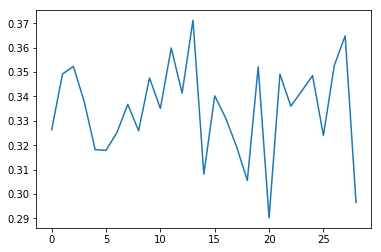


 Current running on: Epoch  16  Training auc: 0.7833207958913696


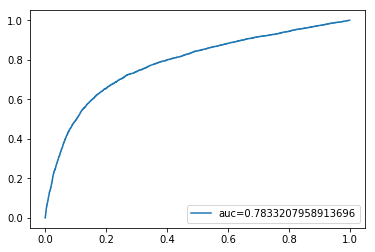


 Current running on: Epoch  16  validation auc: 0.7515077152069819


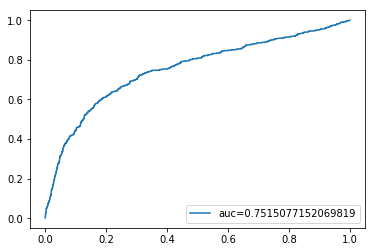


 Current running on: Epoch  16  test auc: 0.7969681633492214


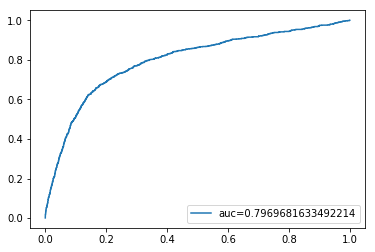

Epoch  16 Summary:  Training_auc : 0.7833207958913696  , Validation_auc :  0.7515077152069819  ,& Test_auc :  0.7969681633492214  Avg Loss:  0.3346746719144638 Train Time (0m 54s) Eval Time (0m 16s)

 Current running on: Epoch  17 Training loss:  Average loss 0.33422223198576145
[0.3328513954745745, 0.3079951169851383, 0.3367593154207775, 0.35826186010292954, 0.3256279026351067, 0.35568449581138883, 0.32263741793583905, 0.3257184291523131, 0.335181812879136, 0.33838120135101873, 0.33126015899500444, 0.3483127594828011, 0.3544571649207588, 0.32410708826045925, 0.3029922562466327, 0.3455038981375454, 0.2833447509344511, 0.32873211446201095, 0.3496988539307331, 0.32940796719299853, 0.34753558952139063, 0.33942310303667045, 0.33761209132001024, 0.3445223874959816, 0.3563384190225806, 0.3185403629284401, 0.3390692590143863, 0.3560989323554486, 0.3163886225805545] 
 train loss plot


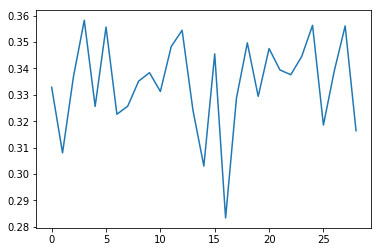


 Current running on: Epoch  17  Training auc: 0.7870686004608356


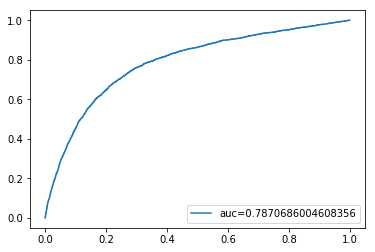


 Current running on: Epoch  17  validation auc: 0.7619640487036954


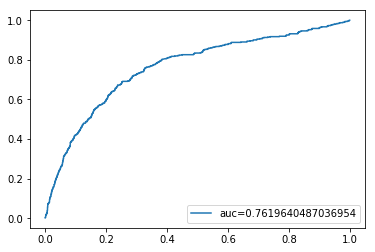


 Current running on: Epoch  17  test auc: 0.7875889575073487


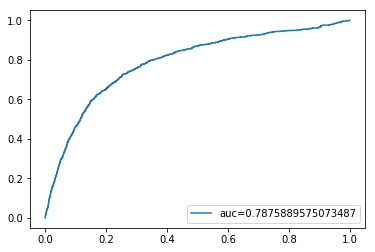

Epoch  17 Summary:  Training_auc : 0.7870686004608356  , Validation_auc :  0.7619640487036954  ,& Test_auc :  0.7875889575073487  Avg Loss:  0.33422223198576145 Train Time (0m 54s) Eval Time (0m 16s)

 Current running on: Epoch  18 Training loss:  Average loss 0.333140651989427
[0.32635402103506883, 0.30928459791034035, 0.3212390686569603, 0.3504866677774362, 0.3429826553817857, 0.3062381270279666, 0.3266571142743944, 0.33159207061846335, 0.32002149046465306, 0.34956621491591794, 0.34491963601349424, 0.3530123332218791, 0.3368705881935766, 0.29743806821771407, 0.32397536727020715, 0.3400191262069029, 0.3535454181144414, 0.3100313467873435, 0.35520020968362226, 0.3082256561988943, 0.34634888252971857, 0.3108695822831487, 0.34285976391359146, 0.32770169719316256, 0.348571306243859, 0.3305736407073782, 0.3792586336804691, 0.31166599814726953, 0.35556962502372336] 
 train loss plot


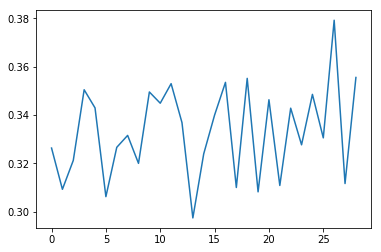


 Current running on: Epoch  18  Training auc: 0.7938642347294235


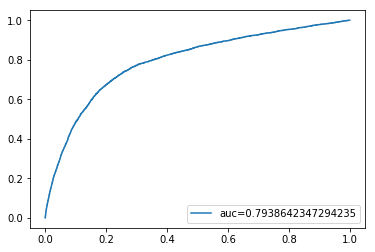


 Current running on: Epoch  18  validation auc: 0.769584451449576


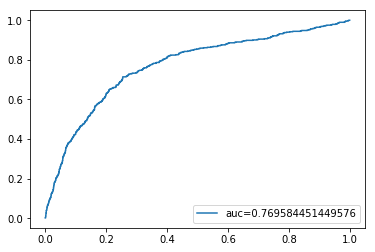


 Current running on: Epoch  18  test auc: 0.7967193991477701


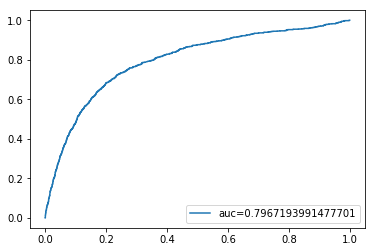

Epoch  18 Summary:  Training_auc : 0.7938642347294235  , Validation_auc :  0.769584451449576  ,& Test_auc :  0.7967193991477701  Avg Loss:  0.333140651989427 Train Time (0m 54s) Eval Time (0m 23s)

 Current running on: Epoch  19 Training loss:  Average loss 0.33185271043666953
[0.34564915344612973, 0.31992926590942694, 0.3180971854975031, 0.3089768209638278, 0.34835852580247595, 0.32610061075500835, 0.33929017021442637, 0.36774947669209723, 0.30229905302454196, 0.3495024961108866, 0.3291155430341856, 0.35859368716757034, 0.30381664773808736, 0.3080218281435268, 0.3043320136038615, 0.308881044893983, 0.39150378796581936, 0.34941270414825887, 0.34081540262769305, 0.3393090846525847, 0.3495234956283002, 0.31306175991456986, 0.3211185609417007, 0.3383811780932315, 0.3374430087156334, 0.30856226829053773, 0.35084810893384566, 0.2935649154094599, 0.3514708043442406] 
 train loss plot


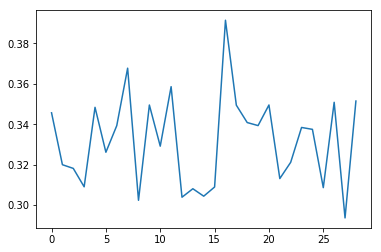


 Current running on: Epoch  19  Training auc: 0.7832404678452225


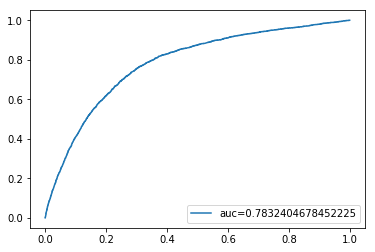


 Current running on: Epoch  19  validation auc: 0.7639300754554291


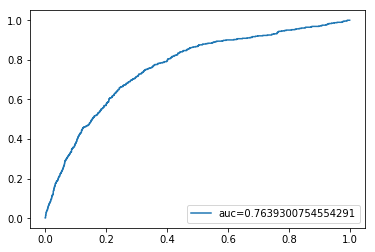


 Current running on: Epoch  19  test auc: 0.7919630330549767


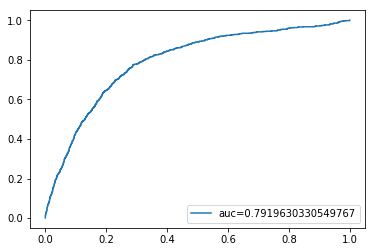

Epoch  19 Summary:  Training_auc : 0.7832404678452225  , Validation_auc :  0.7639300754554291  ,& Test_auc :  0.7919630330549767  Avg Loss:  0.33185271043666953 Train Time (0m 57s) Eval Time (0m 16s)


In [15]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    TVT.auc_plot(y_real, y_hat)
    valid_auc, y_real, y_hat  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    TVT.auc_plot(y_real, y_hat)
    test_auc, y_real, y_hat = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,& Test_auc : " , test_auc, " Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)

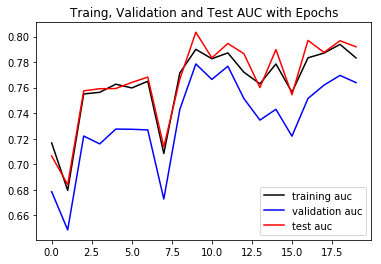

In [16]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label = 'test auc')
plt.title('Traing, Validation and Test AUC with Epochs' )
#plt.xtickes(np.arange(epoches))
plt.legend(loc= 'lower right')
plt.show()

In [18]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg,valid_auc_fg, test_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_dim128_pretrained')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

Plotly is not rendered on github.The interactive plot is available at **<https://plot.ly/~GinnyJZ/52/training-auc-validation-auc-test-auc/>**

Or you can see a static plot here:

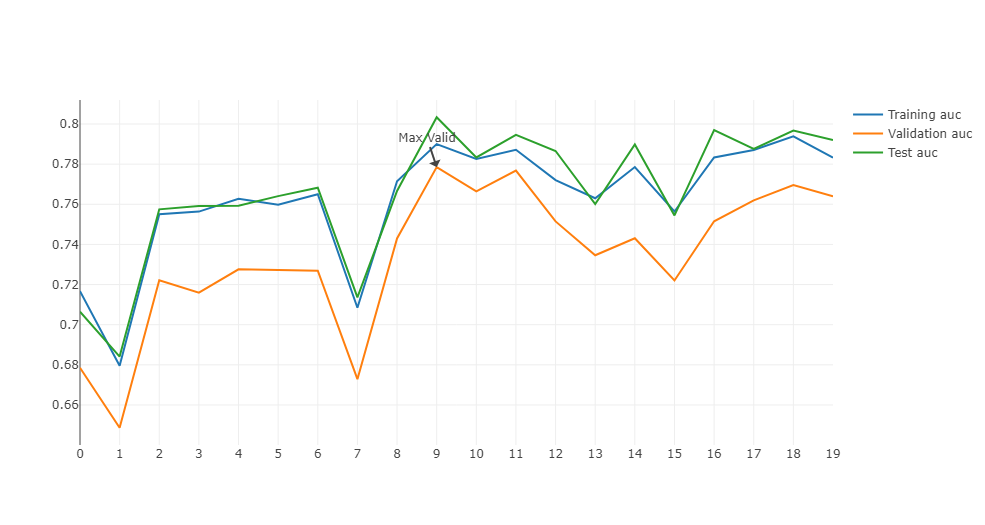

In [1]:
from IPython.display import Image
Image('img/LR_Auc_dim128_pretrained.png')